# Palmer Penguins

This notebook uses [Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/) {cite:p}`palmerpenguins`. The dataset in CSV format used is downloaded from [here](https://gist.github.com/slopp/ce3b90b9168f2f921784de84fa445651).

The following tutorial is from [Increase citations, ease review & foster collaboration](https://ml.recipes) book by [Jesper Dramsch](https://ml.recipes).

## Data Preparation

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins.csv"
# Execute on cloud platform? (e.g. colab), try this path instead
# DATA_FILEPATH = "https://raw.githubusercontent.com/jeepchinnawat/edumat-book/main/data/penguins.csv"

penguins = pd.read_csv(DATA_FILEPATH)
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


In [2]:
penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [3]:
penguins_prep = penguins.dropna(axis='rows')

num_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_features = ["sex"]
features = num_features + cat_features
target = ["species"]

## Exploratory Data Analysis

In [4]:
penguins_prep.describe()

,rowid,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,174.324324,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,98.386547,5.468668,1.969235,14.015765,805.215802,0.812944
min,1.000000,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,90.000000,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,173.000000,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,259.000000,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,344.000000,59.600000,21.500000,231.000000,6300.000000,2009.000000


array([[<Axes: title={'center': 'bill_length_mm'}>,
        <Axes: title={'center': 'bill_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'body_mass_g'}>]], dtype=object)

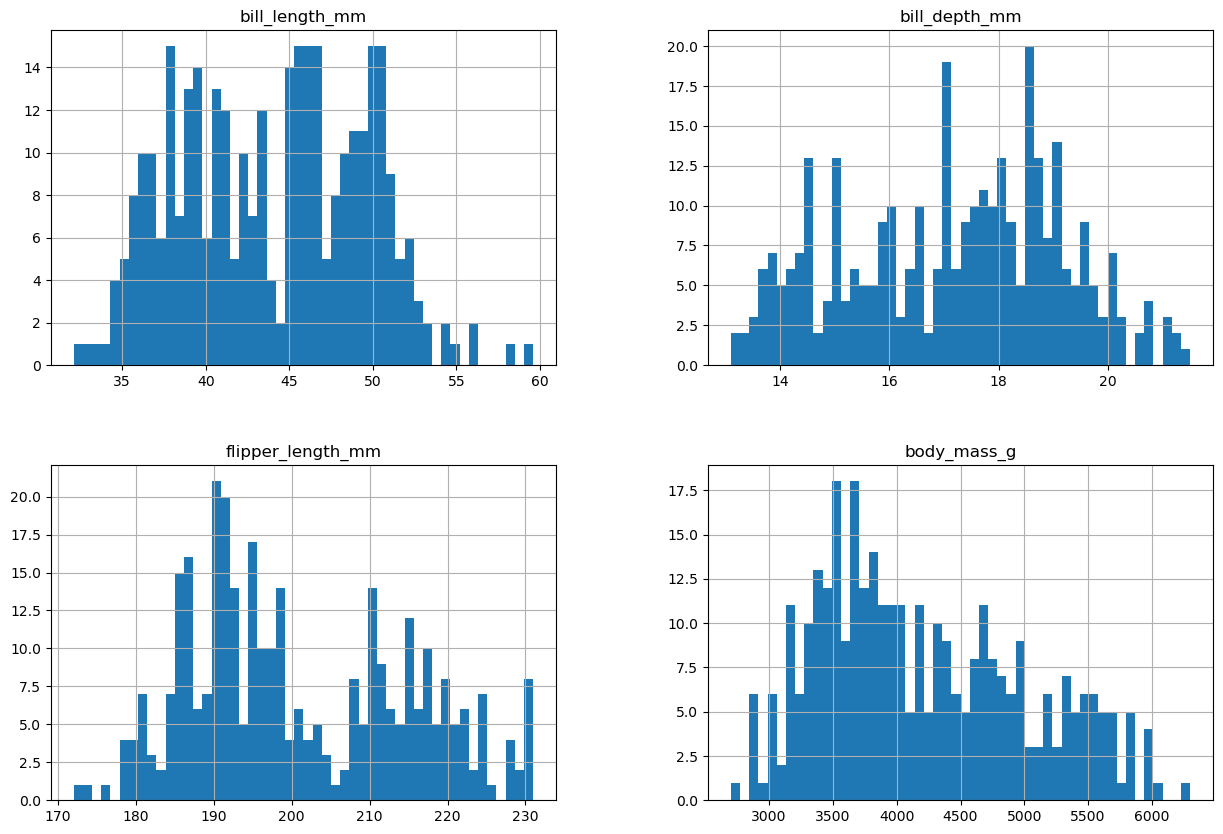

In [5]:
penguins_prep[num_features].hist(bins=50, figsize=(15,10))

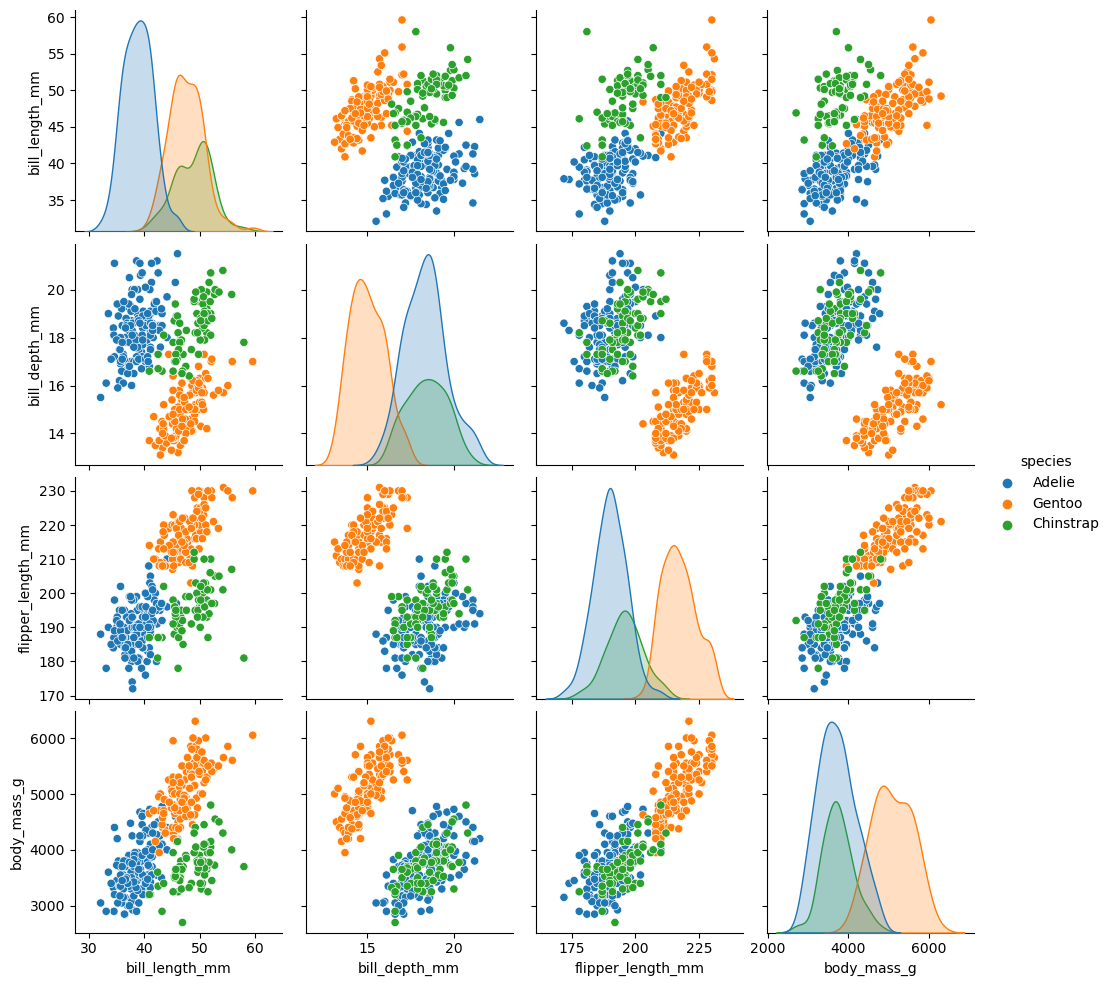

In [6]:
import seaborn as sns

pairplot_figure = sns.pairplot(penguins_prep[num_features+['species']], hue="species")

In [7]:
penguins_final = penguins_prep[features+target]
penguins_final

# DATA_CLEAN_FILEPATH = DATA_FOLDER / "penguins_final.csv"
# penguins_final.to_csv(DATA_CLEAN_FILEPATH, index=False)

## Model 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import accuracy_score as acc
from sklearn.utils import resample

from ipywidgets import interact
import ipywidgets as widgets

def svm_interact(sFeatures, trainsize, mislabel):
    status_widget.value = 'Calculating...'
    selected = np.array(sFeatures)
    X, y = penguins_final[selected], penguins_final[target[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainsize, random_state=21, stratify=y)

    if mislabel > 0.0:
        y_mis = resample(y_train, n_samples=int(y_train.shape[0]*mislabel), replace=False, random_state=21)
        for i in y_mis.index:
            label=['Chinstrap','Gentoo','Adelie']
            label.remove(y_mis[i])
            newlabel = resample(label, n_samples=1)[0]
            y_train[i] = newlabel

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    if 'sex' in selected:
        transformers=[
            ('num', num_transformer, selected[:-1]),
            ('cat', cat_transformer, selected[-1:])
        ]
    else:
        transformers=[
            ('num', num_transformer, selected)
        ]
        
    preprocessor = ColumnTransformer(transformers=transformers)
    
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC()),
    ])

    mcc_scorer = make_scorer(mcc)
    acc_scorer = make_scorer(acc)
    scores = cross_validate(model, X_train, y_train, cv=5,
                            scoring={"MCC": mcc_scorer, "ACC": acc_scorer})

    print("Cross Validation on training set")
    for k, v in scores.items():
        print(k, " : ", v)
    print("Avg ACC in CV: ", np.average(scores["test_ACC"]))
    print("Avg MCC in CV: ", np.average(scores["test_MCC"]))
    print()

    # model = model.fit(X_train, y_train)
    # print("Evaluation on test set")
    # print("ACC: ", acc_scorer(model, X_test, y_test))
    # print("MCC: ", mcc_scorer(model, X_test, y_test))
    print(X_train.shape, y_train.shape)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, train_size=0.8, random_state=21, stratify=y_train)
    model = model.fit(X2_train, y2_train)
    print("Evaluation on test set")
    print("ACC: ", acc_scorer(model, X2_test, y2_test))
    print("MCC: ", mcc_scorer(model, X2_test, y2_test))
    
    
    status_widget.value = 'Calculation completed!'

features_widget = widgets.SelectMultiple(
    options=features,
    value=[features[0], features[1]],
    description='Features:',
    disabled=False
)
trainsize_widget = widgets.FloatSlider(
    value=0.7,
    min=0.5,
    max=0.8,
    step=0.05,
    description='%train data:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0%',
)
mislabel_widget = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=0.5,
    step=0.005,
    description='Mislabeled:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1%',
)
status_widget = widgets.Label(value='')

interact(svm_interact, sFeatures=features_widget, trainsize=trainsize_widget, mislabel=mislabel_widget)
display(status_widget)

interactive(children=(SelectMultiple(description='Features:', index=(0, 1), options=('bill_length_mm', 'bill_d…

Label(value='Calculation completed!')